**Style transfer**

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the second stack. The deepest convolutional layer in the network is conv_5_4.

In [0]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

In [0]:
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

**Load in VGG19 (features)**

VGG19 is split into two portions:

1.   vgg19.features, which are all the convolutional and pooling layers
2.   vgg19.classifier, which are the three linear, classifier layers at the end

We only need the features portion, which we're going to load in and "freeze" the weights of, below.

In [51]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg_m = models.vgg19(pretrained=True)
vgg_m

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [52]:
vgg = vgg_m.features
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [53]:
vgg_c = vgg_m.classifier
vgg_c

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [0]:
# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

**Load in Content and Style Images**

Mounted at /content/gdrive


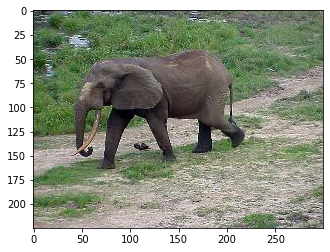

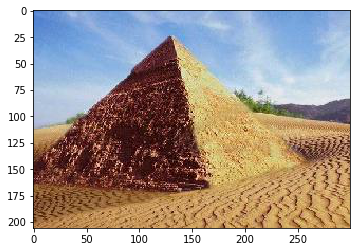

In [55]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

content_path = '/content/gdrive/My Drive/Colab Notebooks/Intro to Deep Learning with PyTorch/image_0002.jpg'
style_path = '/content/gdrive/My Drive/Colab Notebooks/Intro to Deep Learning with PyTorch/image_0003.jpg'

content_image = Image.open(content_path)
# print(content_image.size)       (300, 225)

style_image = Image.open(style_path)
# print(style_image.size)         (300, 206)

plt.imshow(content_image)
plt.show()

plt.imshow(style_image)
plt.show()

# print(content_image.shape)      # This will fail as not converted to tensor yet
# print(style_image.shape)        # This will fail as not converted to tensor yet

**Create data transform**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


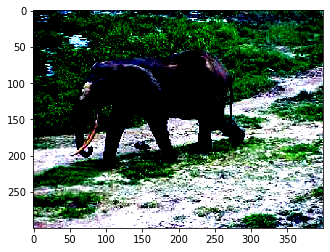

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


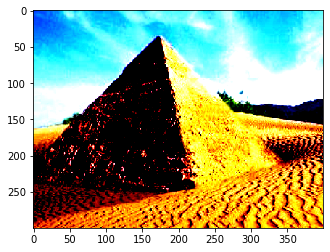

In [56]:
in_transform = transforms.Compose([transforms.Resize((300, 400)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406),
                                                        (0.229, 0.224, 0.225))])

# mean = [0.485, 0.456, 0.406] # Here it's ImageNet statistics
# std = [0.229, 0.224, 0.225]
# If i remove transforms.Normalize, then a normal image appears

content_image = in_transform(content_image)
# print(content_image.shape)                  torch.Size([3, 300, 400]). The transforms.Normalize does not affect the shape

style_image = in_transform(style_image)
# print(style_image.shape)                    torch.Size([3, 300, 400]). The transforms.Normalize does not affect the shape

c_image=content_image.permute(1,2,0)
# print(c_image.shape)                  torch.Size([300, 400, 3])
plt.imshow(c_image)
plt.show()

s_image=style_image.permute(1,2,0)
# print(s_image.shape)                  torch.Size([300, 400, 3])
plt.imshow(s_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


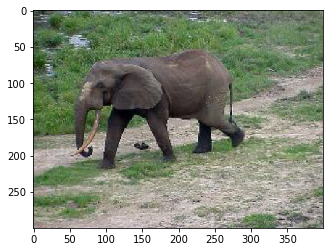

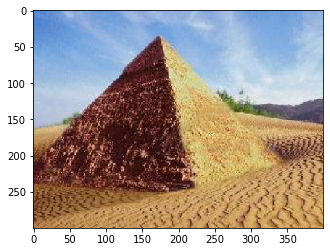

In [57]:
# We can also display normal images by undoing the normalization

c_image = c_image.numpy()
# print(c_image.shape)         (300, 400, 3)
c_image = c_image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
plt.imshow(c_image)
plt.show()

s_image = s_image.numpy()
# print(s_image.shape)         (300, 400, 3)
s_image = s_image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
plt.imshow(s_image)
plt.show()

**Adding batch dimension**

We have to add the batch dimension which alongside rgb channels, as well as height and width is the expected input shape for 2D convolution layers in Pytorch.

In [0]:
content_image = content_image.unsqueeze(0)
# print(content_image.shape)                  torch.Size([1, 3, 300, 400])

style_image = style_image.unsqueeze(0)
# print(style_image.shape)                    torch.Size([1, 3, 300, 400])

**Content and Style Features**

In [0]:
def get_features(image, model, layers=None):
  """ Run an image forward through a model and get the features for 
      a set of layers.
  """
  
  ## Need the layers for the content and style representations of an image
  if layers is None:
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content representation
              '28': 'conv5_1'}
      
  features = {}
  x = image
  # model._modules is a dictionary holding each module in the model
  for name, layer in model._modules.items():
    # print(name)     0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
    # print(layer)    can't print here all but they are these upto 36:   Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                                                                        #ReLU(inplace=True)
                                                                        #Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                                                                        #ReLU(inplace=True) 
    x = layer(x)     # this is like prediction. image passed through all the layers 
    if name in layers:
      # print(name)   0 5 10 19 21 28
      # print(layers[name])    conv1_1 conv2_1 conv3_1 conv4_1 conv4_2 conv5_1
      features[layers[name]] = x    # this assigns the prediction to layers[name]
          
  return features

**Gram Matrix**

The output of every convolutional layer is a Tensor with dimensions associated with the batch_size, a depth d and some height and width (h, w). The Gram matrix of a convolutional layer can be calculated as follows:

*   Get the depth, height, and width of a tensor using batch_size, d, h, w = tensor.size
*   Reshape that tensor so that the spatial dimensions are flattened
*   Calculate the gram matrix by multiplying the reshaped tensor by it's transpose

Note: You can multiply two matrices using torch.mm(matrix1, matrix2).

In [0]:
def gram_matrix(tensor):  
  # get the batch_size, depth, height, and width of the Tensor
  _, d, h, w = tensor.size()
  
  # reshape so we're multiplying the features for each channel
  tensor = tensor.view(d, h * w)
  
  # calculate the gram matrix
  gram = torch.mm(tensor, tensor.t())
  
  return gram

**Putting it all Together**

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [0]:
# get content and style features only once before training
content_features = get_features(content_image, vgg)
style_features = get_features(style_image, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content_image.clone().requires_grad_(True)
# print(target.shape)              torch.Size([1, 3, 300, 400])

**Loss and Weights**

Just like in the paper, we define an alpha (content_weight) and a beta (style_weight). This ratio will affect how stylized your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

**Updating the Target & Calculating Losses**

The content loss will be the mean squared difference between the target and content features at layer conv4_2. This can be calculated as follows:

content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)


---


The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary style_weights.

You'll calculate the gram matrix for the target image, target_gram and style image style_gram at each of these layers and compare those gram matrices, calculating the layer_style_loss. Later, you'll see that this value is normalized by the size of the layer.


---

Finally, you'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!

In [63]:
# for displaying the target image, intermittently
show_every = 100

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
training_epochs = 1000  # decide how many iterations to update your image (5000)

for epoch in range(training_epochs):
    
  # get the features from your target image
  target_features = get_features(target, vgg)
  
  # the content loss
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  
  # the style loss
  # initialize the style loss to 0
  style_loss = 0
  # then add to it for each layer's gram matrix loss
  for layer in style_weights:
    # get the "target" style representation for the layer
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    # get the "style" style representation
    style_gram = style_grams[layer]
    # the style loss for one layer, weighted appropriately
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    # add to the style loss
    style_loss += layer_style_loss / (d * h * w)
        
  # calculate the *total* loss
  total_loss = content_weight * content_loss + style_weight * style_loss

  # update your target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  # display intermediate images and print the loss
  if  epoch % show_every == 0:
    print('Total loss: ', total_loss.item())
    # # print(target.shape)       torch.Size([1, 3, 300, 400])
    # target = target.squeeze()
    # # print(target.shape)       torch.Size([3, 300, 400])
    # target = target.permute(1,2,0)
    # target = target.detach()
    # target = target.numpy()
    # target = target * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    # target = target.clip(0, 1)
    # plt.imshow(target)
    # plt.show()

Total loss:  73862168.0
Total loss:  28340958.0
Total loss:  20176120.0
Total loss:  14776320.0
Total loss:  9399058.0


KeyboardInterrupt: ignored

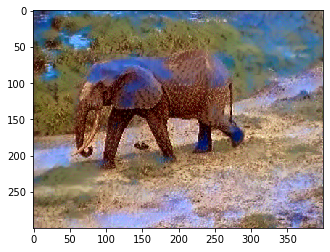

In [64]:
# print(target.shape)       torch.Size([1, 3, 300, 400])
target = target.squeeze()
# print(target.shape)       torch.Size([3, 300, 400])
target = target.permute(1,2,0)
target = target.detach()
target = target.numpy()
target = target * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
target = target.clip(0, 1)
plt.imshow(target)
plt.show()